In [288]:
from qiskit.visualization import plot_histogram
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute, IBMQ
import numpy as np
from qiskit.tools.monitor import job_monitor

In [289]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [290]:
def xor(qc, elements, input, output):
    for element in elements:
        qc.cx(input[element], output)

In [291]:
def sudoku_oracle(qc, clause_qubits, output_qubit):
    for i in range(4):
        qc.cx(i, clause_qubits[0])

    for i in range(2):
        qc.mct([0 + i * 2, 1 + i * 2], clause_qubits[0])

    qc.mct([0, 3], clause_qubits[0])
    qc.mct([1, 2], clause_qubits[0])
    
    qc.mct([0, 1, 2], clause_qubits[0])
    qc.mct([0, 1, 3], clause_qubits[0])
    qc.mct([0, 2, 3], clause_qubits[0])
    qc.mct([1, 2, 3], clause_qubits[0])
    
    qc.mct(clause_qubits, output_qubit)

    for i in range(4):
        qc.cx(i, clause_qubits[0])

    for i in range(2):
        qc.mct([0 + i * 2, 1 + i * 2], clause_qubits[0])
    
    qc.mct([0, 1, 2], clause_qubits[0])
    qc.mct([0, 1, 3], clause_qubits[0])
    qc.mct([0, 2, 3], clause_qubits[0])
    qc.mct([1, 2, 3], clause_qubits[0])

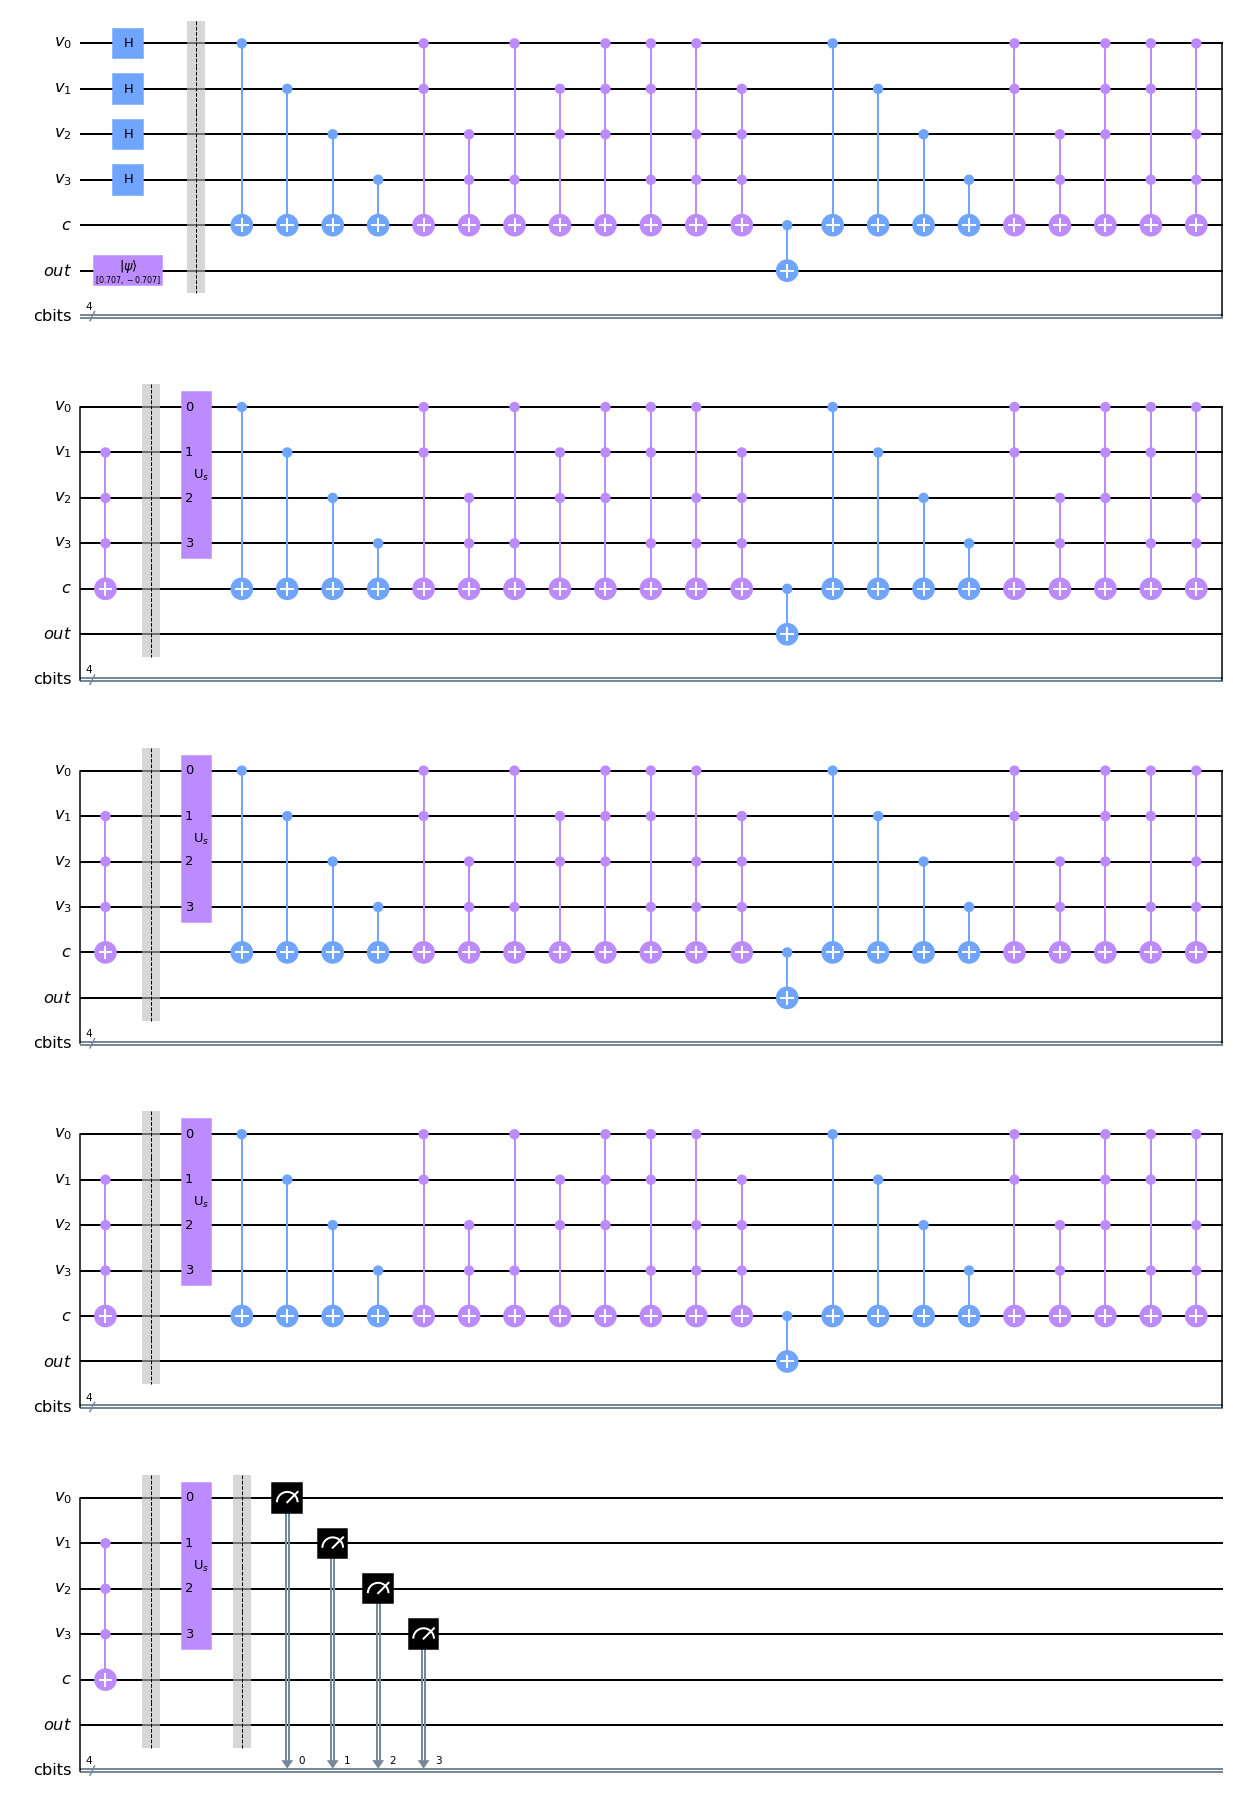

In [292]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(1, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
sudoku = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
sudoku.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
sudoku.h(var_qubits)
sudoku.barrier()  # for visual separation

for _ in range(4):
    sudoku_oracle(sudoku, clause_qubits, output_qubit)
    sudoku.barrier()  # for visual separation
    # Apply our diffuser
    sudoku.append(diffuser(4), range(4))

sudoku.barrier()  # for visual separation
sudoku.measure(var_qubits, cbits)
sudoku.draw('mpl')

In [293]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
device = provider.get_backend('ibmq_qasm_simulator')

ibmqfactory.load_account:WARNING:2022-08-09 04:13:22,832: Credentials are already in use. The existing account in the session will be replaced.


In [294]:
job = execute(sudoku, backend=device, shots=10000)
print(job.job_id())
job_monitor(job)

62f1c2c32ad0939a69908ea2
Job Status: job has successfully run


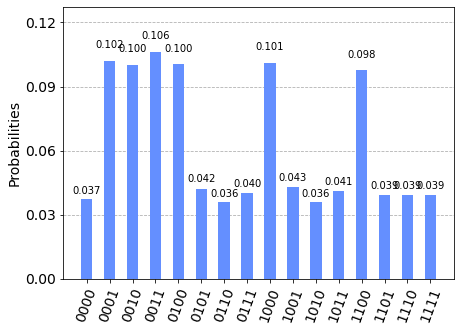

In [295]:
results = job.result()
counts = results.get_counts()
plot_histogram(counts)